In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu
from jax.experimental.ode import odeint

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xvl9i5ih because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


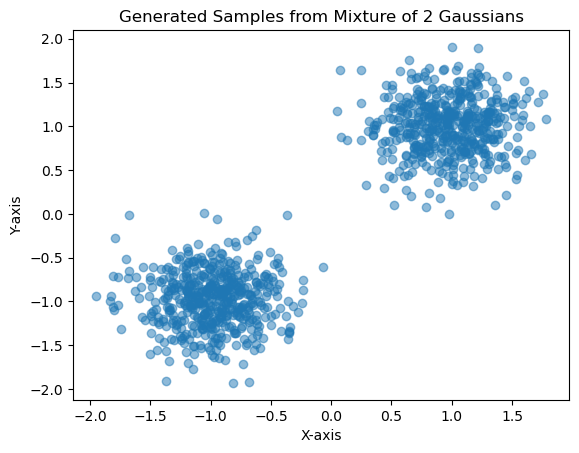

In [2]:
# Chat GPT generated code to sample from mixture of 2 2-dimensional Gaussians

# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-1., -1.])
covariance1 = np.array([[.1, 0.], [0., .1]])
precision1 = inv(covariance1)
weight1 = .5

mean2 = np.array([1., 1.])
covariance2 = np.array([[.1, 0.], [0., .1]])
precision2 = inv(covariance2)
weight2 = .5

# Generate synthetic data
num_samples = 1000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]
generated_samples = generate_samples(num_samples, means, covariances, weights)

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [3]:
# goal is to use a neural ODE to map Gaussian noise to samples from bimodal distribution

In [4]:
# problem dimension
d = 2

# neural net dimension
h = 8

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d+1], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn_int_z(y, t, lmbda):
    
    # weights and biases of nn
    W1, b1, W3, b3 = reshape(lmbda)
    
    # hidden layer
    h = jnp.sin(jnp.einsum('ij,...j->...i', W1, jnp.append(y, t)) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', W2, h) + b2)
    
    # output
    dz_dt = jnp.einsum('ij,...j->...i', W3, h) + b3
    
    return dz_dt #  * (1. - jnp.abs(y)/2.)

# Jacobian of nn_int 
jac_nn_int = jit(jacfwd(nn_int_z))

@jit
def nn_int(aug_y, t, lmbda):
    
    # unpack augmented y
    y, log_pz = aug_y
    
    # dz_dt 
    dz_dt = nn_int_z(y, t, lmbda)
    
    # log likelihood of z_t
    dlog_pz_dt = -jnp.trace(jac_nn_int(y, t, lmbda))
    
    return dz_dt, dlog_pz_dt

# log likelihood of standard Gaussian
@jit 
def log_py(y):
    return -jnp.dot(y, y)/2. - len(y)/2 * jnp.log(2.*np.pi)

@jit
def T(y, lmbda):
    
    # initial condition for log_py
    log_py0 = log_py(y)
    
    # integrate NN and log likelihood of z_t
    z, log_pz = odeint(nn_int, (y, log_py0), jnp.array([0., 1.]), lmbda)

    return z[-1], log_pz[-1]

@jit
def Tz(y, lmbda):
    
    # integrate NN and log likelihood of z_t
    z = odeint(nn_int_z, y, jnp.array([0., 1.]), lmbda)

    return z[-1]
batch_T = vmap(Tz, (0, None))

# gradient of T 
grad_T = jit(jacrev(T, 1))

In [5]:
# nll of true posterior
@jit 
def neg_log_likelihood(zi):
    # l1 = weight1 * N(zi | m1, C1)
    # l2 = weight2 * N(zi | m2, C2)
    l1 = weight1 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance1))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean1, precision1, zi-mean1) / 2.)
    l2 = weight2 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance2))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean2, precision2, zi-mean2) / 2.)
    return -jnp.log(l1 + l2)
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    KL = 0.
    for yi in y:
        # transform yi and compute log_p(zt)
        zi, log_pzi = T(yi, lmbda)
        
        # divergence btw true posterior
        KL += neg_log_likelihood(zi) / n_sample
        
        # entropy
        KL += log_pzi / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    
    grad_KL = 0.
    for yi in y:
        # forward pass
        zi, log_pzi = T(yi, lmbda)
        
        # backward pass
        grad_zi, grad_log_pzi = grad_T(yi, lmbda)
        grad_KL += np.einsum('i,ij->j', grad_neg_log_likelihood(zi), grad_zi) / n_sample
        grad_KL += grad_log_pzi / n_sample
        
    return grad_KL

In [6]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=1000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=10)))

        gradient = np.nan_to_num(grad_f(params))
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [7]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 11.065
KL 1.981
KL 4.034
KL 3.209
KL 1.647
KL 3.017
KL 2.337
KL 0.552
KL 0.301
KL 1.266
KL 2.893
KL 1.840
KL 0.567
KL 0.895
KL 1.161
KL 0.958
KL 0.089
KL 0.796
KL 0.587
KL 0.619
KL 0.919
KL 0.804
KL 0.821
KL 0.900
KL 1.440
KL 0.783
KL 0.943
KL 0.843
KL 0.485
KL 0.424
KL 1.267
KL 1.058
KL 0.437
KL 0.726
KL 1.231
KL 1.380
KL 0.486
KL 1.421
KL 0.555
KL 0.960
KL 0.431
KL 1.188
KL 0.447
KL 0.588
KL 0.753
KL 0.192
KL 0.760
KL 1.133
KL 0.397
KL 0.997
KL 0.886
KL 0.260
KL 0.039
KL 0.955
KL 0.671
KL 0.393
KL 0.948
KL 1.202
KL 0.776
KL 0.348
KL 0.905
KL 0.292
KL 0.121
KL 0.476
KL 0.522
KL 0.781
KL 0.243
KL 0.422
KL 0.522
KL -0.106
KL 1.338
KL 0.225
KL -0.046
KL 0.026
KL 0.123
KL 0.239
KL -0.034
KL 0.662
KL -0.070
KL 0.176
KL 0.157
KL -0.035
KL 0.089
KL 0.333
KL 0.128
KL 0.084
KL 0.880
KL -0.218
KL 0.226
KL 0.249
KL 0.157
KL 0.169
KL 0.110
KL 0.782
KL -0.198
KL 0.080
KL 0.145
KL 0.521
KL 0.025
KL 0.460


In [8]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = batch_T(y, lmbda)

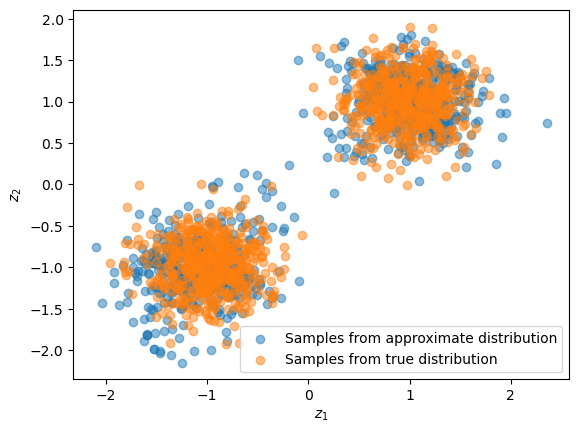

In [9]:
plt.scatter(z[:, 0], z[:, 1], alpha=.5, label='Samples from approximate distribution')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label="Samples from true distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.legend()
plt.show()